In [ ]:
pip install sdv

In [352]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import re
import time
from sdv.tabular import GaussianCopula, CTGAN, CopulaGAN, TVAE
from sdv.constraints import Range, ScalarRange, Inequality, ScalarInequality, create_custom_constraint
from copy import deepcopy

<Axes: >

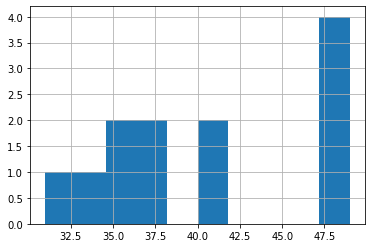

In [115]:
from sdv.demo import load_tabular_demo
employees = load_tabular_demo()
employees['age'].hist()

In [3]:
data = pd.read_csv('data.csv')

In [4]:
data.drop(columns=['Name'], axis=1, inplace=True)

In [5]:
data.head()

,Date_of_birth,Opening_date,Expiry_date,Credit_limit,Statement_balance,Available_credit
0,1949-08-17,2008-09-02,2013-09-02,38000.0,29297.69,8702.31
1,1938-07-04,2019-09-08,2024-09-08,19500.0,15628.50,3871.50
2,1927-03-28,2019-04-23,2024-04-23,11500.0,7388.34,4111.66
3,1936-01-17,2021-10-27,2026-10-27,68500.0,32060.39,36439.61
4,1960-09-05,2010-10-02,2015-10-02,72000.0,56148.13,15851.87


In [6]:
data.dtypes

Date_of_birth         object
Opening_date          object
Expiry_date           object
Credit_limit         float64
Statement_balance    float64
Available_credit     float64
dtype: object

In [711]:
def is_valid_arithmetic_equality(column_names, data):
    is_equal = [data[column_names[0]] == data[column_names[1]] + data[column_names[2]]][0]
    return is_equal
    
arithmetic_equality_constraint = create_custom_constraint(is_valid_fn = is_valid_arithmetic_equality)

def is_valid_arithmetic_inequality(column_names, data):
    is_equal = [data[column_names[0]] >= data[column_names[1]] + column_names[2]][0]
    return is_equal

arithmetic_inequality_constraint = create_custom_constraint(is_valid_fn = is_valid_arithmetic_inequality)

In [706]:
d = Detector(data, 0.95)
d.detect_inequality()
d.detect_arithmetic_inequality()
d.arithmetic_inequality_dict

2 relationships detected
Execution Time: 1.3496 seconds
2 relationships detected
Execution Time: 0.4032 seconds


{'Expiry_date': [['Opening_date', 1826.0], ['Date_of_birth', 8425.0]],
 'Credit_limit': [['Statement_balance', 3.9400000000023283],
  ['Available_credit', 7.260000000000218]]}

In [707]:
d.constraints

[]

In [712]:
is_valid_arithmetic_equality(['Credit_limit', 'Statement_balance', 'Available_credit'], d.data)

0       True
1       True
2       True
3       True
4       True
        ... 
1995    True
1996    True
1997    True
1998    True
1999    True
Length: 2000, dtype: bool

In [727]:
class Detector():
    """
    A class to detect deterministic relationships between two/three columns from a given dataset.

    ...

    Attributes
    ----------
    data : Pandas DataFrame
        an input dataset in Pandas DataFrame format
        
    threshold : float
        a cut-off percentage for detection functions to confirm the deterministic relationships
        
    inequality_dict : dictionary
        stores inequality deterministic relationships;
        in which the key is greater than its values
    
    arithmetic_equality_dict : dictionary
        stores deterministic relationships like "A = B + C" among three colomns
    
    arithmetic_inequality_dict : dictionary
        stores deterministic relationships like "A >= B + X" between two colomns
    
    constraints : list
        a list containing constraints for synthetic data generation model training
        
    Methods
    -------
    preprocess():
        Change the dtpyes of date columns to float and 
        drop the rows of the input dataframe which have missing values.
    
    detect_inequality():
        Detect the inequality deterministic relationship between two colomns.
    
    detect_arithmetic_equality():
        Detect the deterministic relationships like "A = B + C" among three colomns.
        
    detect_arithmetic_inequality():
        Detect the deterministic relationships like "A >= B + X" between two colomns.
        
    create_constraints():
        Create constraints for synthetic data generation model training.
    """
    def __init__(self, data, threshold, 
                 inequality_dict={}, inequality_runtime=0,
                 arithmetic_equality_dict={}, arithmetic_equality_runtime=0, 
                 arithmetic_inequality_dict={}, arithmetic_inequality_runtime=0,
                 constraints=[]):
        """
        Constructs all the necessary attributes for the person object.

        Parameters
        ----------
            dataframe : Pandas DataFrame
                an input dataset in Pandas DataFrame format
                
            threshold : float
                a cut-off percentage for detection functions to confirm the deterministic relationships
                
            inequality_dict : dictionary
                an empty dictionary to store inequality deterministic relationships
            
            inequality_runtime : float
                a variable to store the runtime of inequality detection function
    
            arithmetic_equality_dict : dictionary
                an empty dictionary to store deterministic relationships among three columns like "A = B + C"
                
            arithmetic_equality_runtime : float
                a variable to store the runtime of arithmetic equality detection function
            
            arithmetic_inequality : dictionary
                an empty dictionary to store deterministic relationships between two columnslike "A >= B + X"
                
            arithmetic_inequality_runtime : float
                a variable to store the runtime of arithmetic inequality detection function
            
            constarints : list
                an empty list to store contraints for synthetic data generation model training
        """    
        self.data = data
        self.threshold = threshold
        self.inequality_dict = inequality_dict
        self.inequality_runtime = inequality_runtime
        self.arithmetic_equality_dict = arithmetic_equality_dict
        self.arithmetic_equality_runtime = arithmetic_equality_runtime
        self.arithmetic_inequality_dict = arithmetic_inequality_dict 
        self.arithmetic_inequality_runtime = arithmetic_inequality_runtime
        self.constraints = constraints
        
    def preprocess(self):
        """
        Change date columns to float format;
        Handle missing values of the input dataframe;
        Drop the rows with missing values.
        
        Returns:
            None.
        
        Output:
            Running finished message with execution time.
        """
        st = time.time()
        
        data = self.data
        
        ref_dt = pd.Timestamp('1900-01-01')

        str2date = lambda x: dt.strptime(x, "%Y-%m-%d") - ref_dt if x.replace(" ", "") else np.nan
        
        for col in data.columns:
            
            try:
                re.match('^[0-9]{4}\-[0-9]{2}\-[0-9]{2}$', data[col][0])
                
                self.data[col] = self.data[col].apply(str2date)
                self.data[col] = (self.data[col] / np.timedelta64(1, 'D')).astype(float)
                
            except:
                pass
            
        data.dropna(axis=0, inplace=True)
        self.data = data

        et = time.time()
        elapsed_time = et - st
        print("Date types reformatted and missing values handled successfully!\nExecution Time:"
              , round(elapsed_time, 4), "seconds")

    def detect_inequality(self):
        """
        Detect the inequality deterministic relationship between colomns;
        Update the inequality_dictionary of the class object.
        
        Returns:
            None.
        
        Output:
            Number of relationships detected with execution time.
        """
        st = time.time()
        
        data = self.data
        inequality_dict = {}
        
    # Looping through all combinitions of columns
        for i in range(len(data.columns)):
            for j in range(i+1, len(data.columns)):
                
                # Extract the column pairs in float format
                if (data[data.columns[i]].dtypes == 'float' and data[data.columns[j]].dtypes == 'float'):
                    diff = []
                    count = 0
                    for rownum, row in data.iterrows():
                        diff.append(row[i] - row[j])
                    for num in diff:
                        if num < 0:
                            count+=1 
                    if float(count)/len(diff) >= self.threshold:
                        if data.columns[j] in inequality_dict.keys():
                            inequality_dict[data.columns[j]].append(data.columns[i])
                        else:
                            inequality_dict[data.columns[j]] = []
                            inequality_dict[data.columns[j]].append(data.columns[i])
                    elif float(len(diff) - count)/len(diff) >= self.threshold:
                        if data.columns[i] in inequality_dict.keys():
                            inequality_dict[data.columns[i]].append(data.columns[j])
                        else:
                            inequality_dict[data.columns[i]] = []
                            inequality_dict[data.columns[i]].append(data.columns[j])
        
        key_list = []
        remove_list = []
        
        for key in inequality_dict:
            for i in key_list:
                if i in inequality_dict[key]:
                    for j in inequality_dict[i]:
                        inequality_dict[key].append(j)
                    remove_list.append(i)
                    key_list.remove(i)
            key_list.append(key)

        for i in remove_list:
            inequality_dict.pop(i)

        for key in inequality_dict:
            for i in range(0, len(inequality_dict[key])):
                for j in range(i+1, len(inequality_dict[key])):
                    if inequality_dict[key][i] == inequality_dict[key][j]:
                        inequality_dict[key].pop(i)
        
    
        self.inequality_dict = inequality_dict
        
        et = time.time()
        elapsed_time = et - st
        self.inequality_runtime = elapsed_time
        
        print(len(inequality_dict), "relationships detected")
        print("Execution Time:", round(self.inequality_runtime, 4), "seconds")

    def detect_arithmetic_equality(self):
        """
        Detect the deterministic relationships "A = B + C" among three columns;
        Based on the dictionary of inequality deterministic relationships.
        
        Returns:
            None.
        
        Output:
            Number of relationships detected with execution time.    
        """
        st = time.time()
        
        data = self.data
        arithmetic_equality_dict = {}
        
        for key in self.inequality_dict:
            # Check if the len(the list of values of the key) is >= 2 
            if len(self.inequality_dict[key]) >= 2:
                for i in range(len(self.inequality_dict[key])):
                    for j in range(i+1, len(self.inequality_dict[key])):
                        count = 0
                        for index, row in data.iterrows():
                            if (row[key] == row[self.inequality_dict[key][i]] + row[self.inequality_dict[key][j]]):
                                count += 1
                        if float(count) / len(data.index) >= self.threshold:
                            if key in arithmetic_equality_dict.keys():
                                arithmetic_equality_dict[key].append([self.inequality_dict[key][i], self.inequality_dict[key][j]])
                            else:
                                arithmetic_equality_dict[key] = []
                                arithmetic_equality_dict[key].append([self.inequality_dict[key][i], self.inequality_dict[key][j]])
                 
        self.arithmetic_equality_dict = arithmetic_equality_dict
        
        et = time.time()
        elapsed_time = et - st
        self.arithmetic_equality_runtime = elapsed_time
        
        print(len(arithmetic_equality_dict), "relationships detected")
        print("Execution Time:", round(self.arithmetic_equality_runtime, 4), "seconds")
    
    def detect_arithmetic_inequality(self):
        """
        Detect the deterministic relationships "A >= B + X" between two columns;
        Based on the dictionary of inequality deterministic relationships.
        
        Returns:
            None.
        
        Output:
            Number of relationships detected with execution time. 
        """
        st = time.time()
        
        data = self.data
        arithmetic_inequality_dict = {}
        
        for key in self.inequality_dict:
            for value in self.inequality_dict[key]:
                diff = []
                for index, row in data.iterrows():
                    diff.append(row[key] - row[value])
                    
                if key in arithmetic_inequality_dict.keys():
                    arithmetic_inequality_dict[key].append([value, min(diff)])
                else:
                    arithmetic_inequality_dict[key] = []
                    arithmetic_inequality_dict[key].append([value, min(diff)])
        
        self.arithmetic_inequality_dict = arithmetic_inequality_dict
            
        et = time.time()
        elapsed_time = et - st
        self.arithmetic_inequality_runtime = elapsed_time
        
        print(len(arithmetic_inequality_dict), "relationships detected")
        print("Execution Time:", round(self.arithmetic_inequality_runtime, 4), "seconds")
    
    def create_constraints(self, inequality=False, arithmetic_equality=False, arithmetic_inequality=False):
        """
        Create constraints for synthetic data generation model training.
        
        Parameters:
            inequality: bool, default=True
                If True, create constraints for inequality deterministic relationships.
            
            arithmetic_equality: bool, default=True
                If True, create constraints for deterministic relationships like "A = B + C".
            
            arithmetic_inequality: bool, default=True
                If True, create constraints for deterministic relationships like "A >= B + X".
        
        Returns:
            None.
        
        Output:
            Running finished message with execution time.
        """
        st = time.time()
        
        if inequality:
            for key in self.inequality_dict:
                for value in self.inequality_dict[key]:
                    self.constraints.append(Inequality(low_column_name=value, high_column_name=key))
        
        if arithmetic_equality:
            for key in self.arithmetic_equality_dict:
                for value_list in self.arithmetic_equality_dict[key]:
                    columns = [key, value_list[0], value_list[1]]
#                     is_valid = is_valid_arithmetic_equality(columns, self.data)
                    cons = arithmetic_equality_constraint(column_names=columns)
                    self.constraints.append(cons)
                    
        
        if arithmetic_inequality:
            for key in self.arithmetic_inequality_dict:
                for value_list in self.arithmetic_inequality_dict[key]:
                    columns = [key, value_list[0], value_list[1]]
#                     constant = value_list[1]
#                     is_valid = is_valid_arithmetic_inequality(columns, constant, self.data)
                    cons = arithmetic_inequality_constraint(column_names=columns)
                    self.constraints.append(cons)
        et = time.time()
        elapsed_time = et - st
        
        print("Constrainsts created successfully!\nExecution Time:"
              , round(elapsed_time, 4), "seconds")
        
        
        
        
        

In [728]:
d = Detector(data, 0.95)

In [729]:
d.preprocess()

Date types reformatted and missing values handled successfully!
Execution Time: 0.0025 seconds


In [730]:
d.data

,Date_of_birth,Opening_date,Expiry_date,Credit_limit,Statement_balance,Available_credit
0,18125.0,39691.0,41517.0,38000.0,29297.69,8702.31
1,14063.0,43714.0,45541.0,19500.0,15628.50,3871.50
2,9947.0,43576.0,45403.0,11500.0,7388.34,4111.66
3,13164.0,44494.0,46320.0,68500.0,32060.39,36439.61
4,22162.0,40451.0,42277.0,72000.0,56148.13,15851.87
...,...,...,...,...,...,...
1995,7700.0,41297.0,43123.0,34000.0,14430.69,19569.31
1996,28938.0,41456.0,43282.0,69500.0,27018.51,42481.49
1997,23295.0,41951.0,43777.0,68000.0,2701.58,65298.42
1998,9140.0,39081.0,40907.0,19000.0,2614.15,16385.85


In [731]:
d.data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date_of_birth      2000 non-null   float64
 1   Opening_date       2000 non-null   float64
 2   Expiry_date        2000 non-null   float64
 3   Credit_limit       2000 non-null   float64
 4   Statement_balance  2000 non-null   float64
 5   Available_credit   2000 non-null   float64
dtypes: float64(6)
memory usage: 109.4 KB


In [732]:
d.detect_inequality()
d.inequality_dict

2 relationships detected
Execution Time: 1.3293 seconds


{'Expiry_date': ['Opening_date', 'Date_of_birth'],
 'Credit_limit': ['Statement_balance', 'Available_credit']}

In [733]:
d.detect_arithmetic_equality()
d.arithmetic_equality_dict

1 relationships detected
Execution Time: 0.2311 seconds


{'Credit_limit': [['Statement_balance', 'Available_credit']]}

In [734]:
d.detect_arithmetic_inequality()
d.arithmetic_inequality_dict

2 relationships detected
Execution Time: 0.4094 seconds


{'Expiry_date': [['Opening_date', 1826.0], ['Date_of_birth', 8425.0]],
 'Credit_limit': [['Statement_balance', 3.9400000000023283],
  ['Available_credit', 7.260000000000218]]}

In [735]:
d.create_constraints(inequality=True, arithmetic_equality=False, arithmetic_inequality=False)

Constrainsts created successfully!
Execution Time: 0.0002 seconds


In [736]:
d.constraints

In [737]:
model_1 = GaussianCopula(constraints=d.constraints)

In [738]:
model_1.fit(d.data)

/Users/alexlien/Desktop/anaconda3/lib/python3.8/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Expiry_date'] were not found. Using the reject sampling approach instead.
  warnings.warn(
/Users/alexlien/Desktop/anaconda3/lib/python3.8/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
/Users/alexlien/Desktop/anaconda3/lib/python3.8/site-packages/rdt/transformers/numerical.py:100: UserWarning: No rounding scheme detected for column 'Available_credit'. Data will not be rounded.
  warnings.warn(


In [739]:
new_data = model_1.sample(num_rows=200)

Sampling rows: 100%|██████████| 200/200 [00:00<00:00, 1404.13it/s]


In [740]:
new_data.head()

,Date_of_birth,Opening_date,Expiry_date,Credit_limit,Statement_balance,Available_credit
0,16136.0,36881.0,38707.222608,43350.255284,37178.44,9654.098640
1,15958.0,39346.0,41172.223430,107115.865918,49602.17,54793.366912
2,28833.0,37206.0,39032.224254,37124.217638,36046.01,4407.040984
3,24003.0,36938.0,38764.223064,51620.441015,38750.69,28462.231252
4,28237.0,42948.0,44774.223604,121115.224988,56408.40,61478.326952


In [741]:
model_2 = CTGAN(constraints=d.constraints)

In [742]:
model_2.fit(d.data)

/Users/alexlien/Desktop/anaconda3/lib/python3.8/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Expiry_date'] were not found. Using the reject sampling approach instead.
  warnings.warn(
/Users/alexlien/Desktop/anaconda3/lib/python3.8/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
/Users/alexlien/Desktop/anaconda3/lib/python3.8/site-packages/rdt/transformers/numerical.py:100: UserWarning: No rounding scheme detected for column 'Available_credit'. Data will not be rounded.
  warnings.warn(


In [743]:
new_data_2 = model_2.sample(num_rows=200)

Sampling rows: 100%|██████████| 200/200 [00:00<00:00, 1293.29it/s]


In [744]:
new_data_2.head()

,Date_of_birth,Opening_date,Expiry_date,Credit_limit,Statement_balance,Available_credit
0,19383.0,42783.0,44608.819982,66765.235720,34974.03,1925.989237
1,22683.0,41212.0,43038.515804,59984.333623,16830.52,7047.503034
2,25754.0,38166.0,39993.872435,79411.841339,20056.51,10103.063435
3,10633.0,38235.0,40061.084858,40642.987414,10598.74,5862.481667
4,31649.0,37208.0,39036.107278,55929.496934,9642.93,21889.421933


In [745]:
model_3 = CopulaGAN(constraints=d.constraints)

In [746]:
model_3.fit(d.data)

/Users/alexlien/Desktop/anaconda3/lib/python3.8/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Expiry_date'] were not found. Using the reject sampling approach instead.
  warnings.warn(
/Users/alexlien/Desktop/anaconda3/lib/python3.8/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
/Users/alexlien/Desktop/anaconda3/lib/python3.8/site-packages/rdt/transformers/numerical.py:100: UserWarning: No rounding scheme detected for column 'Available_credit'. Data will not be rounded.
  warnings.warn(


In [747]:
new_data_3 = model_3.sample(num_rows=200)

Sampling rows: 100%|██████████| 200/200 [00:00<00:00, 1063.22it/s]


In [748]:
new_data_3.head()

,Date_of_birth,Opening_date,Expiry_date,Credit_limit,Statement_balance,Available_credit
0,5644.0,38963.0,40788.527587,22023.162882,13951.75,19086.076969
1,7078.0,37711.0,39536.477999,101526.993888,40847.21,30370.530805
2,18423.0,40895.0,42719.943388,65875.401893,38679.54,1891.858947
3,37048.0,44912.0,46738.479735,32853.988864,31445.70,17678.075412
4,34986.0,41158.0,42983.496276,6325.944376,154.51,542.673475


In [749]:
model_4 = TVAE(constraints=d.constraints)

In [751]:
model_4.fit(d.data)

/Users/alexlien/Desktop/anaconda3/lib/python3.8/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Expiry_date'] were not found. Using the reject sampling approach instead.
  warnings.warn(
/Users/alexlien/Desktop/anaconda3/lib/python3.8/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
/Users/alexlien/Desktop/anaconda3/lib/python3.8/site-packages/rdt/transformers/numerical.py:100: UserWarning: No rounding scheme detected for column 'Available_credit'. Data will not be rounded.
  warnings.warn(


In [752]:
new_data_4 = model_4.sample(num_rows=200)

Sampling rows: 100%|██████████| 200/200 [00:00<00:00, 1333.15it/s]


In [753]:
new_data_4.head()

,Date_of_birth,Opening_date,Expiry_date,Credit_limit,Statement_balance,Available_credit
0,34442.0,44072.0,45897.632554,44301.458652,7.26,43628.095956
1,6342.0,38574.0,40399.582449,7409.296975,3636.24,5099.439006
2,24203.0,42831.0,44656.212013,39784.537142,24292.73,8786.339947
3,23934.0,43144.0,44970.455597,29577.805343,25175.84,6020.243722
4,9978.0,41494.0,43320.572573,48288.265216,6262.34,39522.402626
